In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append("..")

from utils.funciones_toolbox_ml_final import *
from utils.modulos import *

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, recall_score, balanced_accuracy_score, make_scorer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier





## Problema de negocio

El síndrome metabólico es un conjunto de condiciones médicas que aumentan el riesgo de enfermedades cardiovasculares, diabetes tipo 2 y otros problemas de salud. Estas condiciones incluyen hipertensión arterial, niveles altos de azúcar en la sangre, exceso de grasa abdominal y niveles anormales de colesterol o triglicéridos en la sangre, por lo que se nos pide:

**Identificar a las personas en riesgo para crear posteriormente programas de salud e intervenciones preventivas y personalizadas para éstos pacientes**

## Objetivo técnico

- Crear un modelo supervisado de clasificación

## Métricas

 - El recall de la clase 1 sería la métrica adecuada para evaluar qué tan bien el modelo identifica a todos los pacientes que tienen el síndrome metabólico, donde la clase positiva representa a los pacientes enfermos (clase 1). Al establecer el recall como la métrica objetivo, se prioriza la capacidad del modelo para detectar a todos los pacientes con síndrome metabólico. Esto asegura que el modelo esté optimizado para capturar la mayor cantidad posible de casos positivos, lo que es crucial para identificar a las personas en riesgo y proporcionarles la atención médica adecuada.

## Obtención de los datos

In [2]:
df = pd.read_csv("../data/MetabolicSyndrome.csv")
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,0
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,0
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(7), object(3)
memory usage: 281.5+ KB


In [4]:
describe_df(df)

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
Tipo,int64,int64,object,object,float64,object,float64,float64,int64,float64,float64,int64,int64,int64,int64
Porcentaje_Nulos,0.0,0.0,0.0,8.663057,4.87297,0.0,3.540192,1.082882,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Valores_Unicos,2401,61,2,5,14,6,635,322,3,1383,88,187,93,345,2
Porcentaje_Cardinalidad,100.0,2.540608,0.083299,0.208247,0.58309,0.249896,26.447314,13.411079,0.124948,57.601,3.66514,7.788421,3.873386,14.369013,0.083299


In [5]:
tabla_descriptiva = tipifica_variables(df,10,30)
tabla_descriptiva

,nombre_variable,tipo_sugerido
0,seqn,Numerica Continua
1,Age,Numerica Discreta
2,Sex,Binaria
3,Marital,Categorica
4,Income,Numerica Discreta
5,Race,Categorica
6,WaistCirc,Numerica Discreta
7,BMI,Numerica Discreta
8,Albuminuria,Categorica
9,UrAlbCr,Numerica Continua


In [6]:
descripcion = {"Descripcion":["Índice único", "Edad", "Género", 
                              "Estado civil","Ingresos", "Raza",
                              "Circunferencia Abdominal", "Índice de Masa Corporal",
                              "Medida de Albumina en orina", "Relación Albumina-Creatitina en orina",
                              "Ácido Úrico", "Azúcar en sangre", 
                              "Niveles de colesterol de lipoproteínas de alta densidad('colesterol bueno')",
                              "Triglicéridos", "Indica la presencia (1) o ausencia (0) de síndrome metabólico"
                              ]}
df_descripcion = pd.DataFrame(descripcion)

tabla_descriptiva = pd.concat([tabla_descriptiva, df_descripcion], axis=1)

In [7]:
tabla_descriptiva
tabla_descriptiva

,nombre_variable,tipo_sugerido,Descripcion
0,seqn,Numerica Continua,Índice único
1,Age,Numerica Discreta,Edad
2,Sex,Binaria,Género
3,Marital,Categorica,Estado civil
4,Income,Numerica Discreta,Ingresos
5,Race,Categorica,Raza
6,WaistCirc,Numerica Discreta,Circunferencia Abdominal
7,BMI,Numerica Discreta,Índice de Masa Corporal
8,Albuminuria,Categorica,Medida de Albumina en orina
9,UrAlbCr,Numerica Continua,Relación Albumina-Creatitina en orina


- Voy a eliminar las columnas que no me aportan nada a la hora de realizar el modelo, "seqn" porque es un índice de los pacientes y tiene una cardinalidad del 100%, y elimino "UrAlbCr" porque aporta la misma información que Albuminuria, visto anteriormente en el EDA.

In [8]:
df.drop(columns=["seqn", "UrAlbCr"], inplace= True)

In [9]:
df.isna().sum()

Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

- Hay 4 columnas con valores nulos, de las cuales "Marital" es la única categórica.

In [10]:
df.describe()

,Age,Income,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
count,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,48.691795,4005.253940,98.307254,28.702189,0.154102,5.489046,108.247813,53.369429,128.125364,0.342357
std,17.632852,2954.032186,16.252634,6.662242,0.422780,1.439358,34.820657,15.185537,95.322477,0.474597
min,20.000000,300.000000,56.200000,13.400000,0.000000,1.800000,39.000000,14.000000,26.000000,0.000000
25%,34.000000,1600.000000,86.675000,24.000000,0.000000,4.500000,92.000000,43.000000,75.000000,0.000000
50%,48.000000,2500.000000,97.000000,27.700000,0.000000,5.400000,99.000000,51.000000,103.000000,0.000000
75%,63.000000,6200.000000,107.625000,32.100000,0.000000,6.400000,110.000000,62.000000,150.000000,1.000000
max,80.000000,9000.000000,176.000000,68.700000,2.000000,11.300000,382.000000,156.000000,1562.000000,1.000000


In [11]:
# Verificamos que no hayan duplicados
print(df.duplicated().sum())

0


## Separar en Train y Test

In [12]:
train_set, test_set = train_test_split(df, test_size=0.2, stratify= df["MetabolicSyndrome"],random_state=73)

In [13]:
train_set["MetabolicSyndrome"].value_counts()

MetabolicSyndrome
0    1263
1     657
Name: count, dtype: int64

## Mini EDA

#### Definimos el target

In [14]:
target = "MetabolicSyndrome"

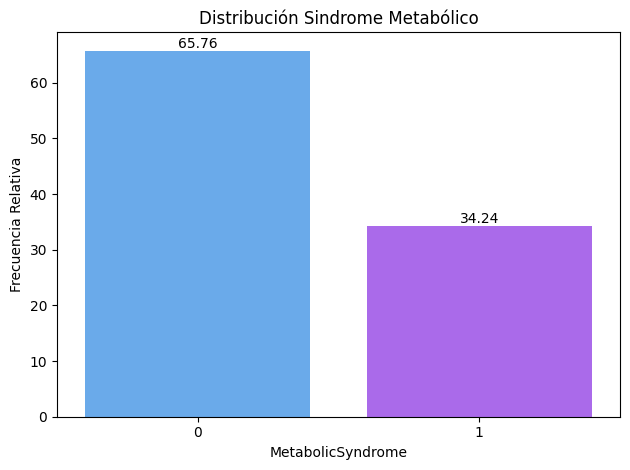

In [15]:
barplot_categorica(df, target)

- El target está desbalanceado, hay mayor concentración de pacientes hacía la clase 0 es decir los pacientes sanos, tendré que tener éste factor en cuenta a la hora de realizar el modelo porque lo que nos interesa conseguir es la mayor precisión en el grupo 1.

In [16]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1920 entries, 651 to 1230
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1920 non-null   int64  
 1   Sex                1920 non-null   object 
 2   Marital            1746 non-null   object 
 3   Income             1821 non-null   float64
 4   Race               1920 non-null   object 
 5   WaistCirc          1858 non-null   float64
 6   BMI                1902 non-null   float64
 7   Albuminuria        1920 non-null   int64  
 8   UricAcid           1920 non-null   float64
 9   BloodGlucose       1920 non-null   int64  
 10  HDL                1920 non-null   int64  
 11  Triglycerides      1920 non-null   int64  
 12  MetabolicSyndrome  1920 non-null   int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 210.0+ KB


In [17]:
features_num = []
features_cat = []

for col in train_set.columns:
    if train_set[col].dtype != "object":
        if col != "MetabolicSyndrome":
            features_num.append(col)
    else:
        features_cat.append(col)


In [18]:
features_cat

['Sex', 'Marital', 'Race']

In [19]:
features_num

['Age',
 'Income',
 'WaistCirc',
 'BMI',
 'Albuminuria',
 'UricAcid',
 'BloodGlucose',
 'HDL',
 'Triglycerides']

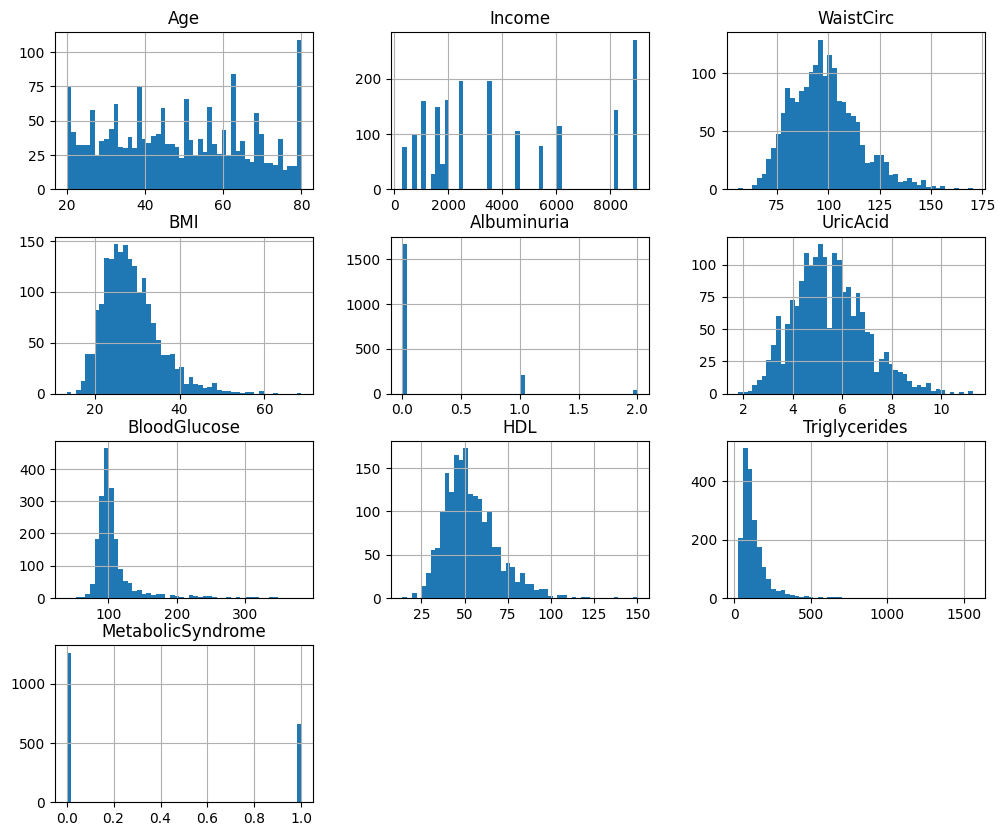

In [20]:
train_set.hist(bins=50, figsize=(12, 10))
plt.show()

- Voy a empezar por imputar nulos a las columnas:

    - Marital: Moda
    - Income: Media
    - WaistCirc: Media
    - BMI:Media                   

In [21]:
waist_circ_media = train_set["WaistCirc"].mean()
bmi_media = train_set["BMI"].mean()
income_media = train_set["Income"].mean()
marital_moda = train_set["Marital"].mode()[0]
train_set["WaistCirc"].fillna(waist_circ_media, inplace=True)
train_set["BMI"].fillna(waist_circ_media, inplace=True)
train_set["Income"].fillna(income_media, inplace = True)
train_set["Marital"].fillna(marital_moda, inplace = True)

- Hago lo mismo al test

In [22]:
test_set["WaistCirc"].fillna(waist_circ_media, inplace=True)
test_set["BMI"].fillna(waist_circ_media, inplace=True)
test_set["Income"].fillna(income_media, inplace = True)
test_set["Race"].fillna(marital_moda, inplace = True)

### Procesado de Features

#### Tratamiento de las features categóricas

In [24]:
train_set = pd.get_dummies(train_set, columns=["Sex", "Marital", "Race"], dtype = int)


In [25]:
train_set

,Age,Income,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome,...,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
651,38,800.0,142.0,48.0,1,7.1,116,59,91,1,...,0,0,1,0,0,1,0,0,0,0
1111,30,9000.0,95.1,28.1,0,5.5,103,41,428,1,...,1,0,0,0,1,0,0,0,0,0
392,41,6200.0,92.1,27.0,0,6.4,94,37,26,0,...,1,0,0,0,0,1,0,0,0,0
1877,54,3500.0,102.7,29.6,0,6.4,104,37,291,1,...,1,0,0,0,0,0,1,0,0,0
962,76,2000.0,84.7,21.2,1,9.6,138,56,157,1,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,21,3500.0,82.7,22.0,0,4.3,89,48,65,0,...,1,0,0,0,0,0,1,0,0,0
2197,26,2000.0,138.2,44.5,0,7.3,107,47,112,1,...,0,0,1,0,1,0,0,0,0,0
1242,51,1700.0,80.4,21.9,0,3.7,91,59,53,0,...,0,1,0,0,0,0,0,1,0,0
1083,47,2500.0,106.6,28.8,0,6.1,93,36,154,1,...,0,0,0,0,0,0,0,0,0,1


In [26]:
test_set = pd.get_dummies(test_set, columns=["Sex", "Marital", "Race"], dtype = int)

#### Tratamiento de features numéricas

In [27]:
# Me hago una copia del train_set y test_set para hacerle el power transformer a todas las features numéricas
train_set_pt = train_set.copy()
test_set_pt = test_set.copy()

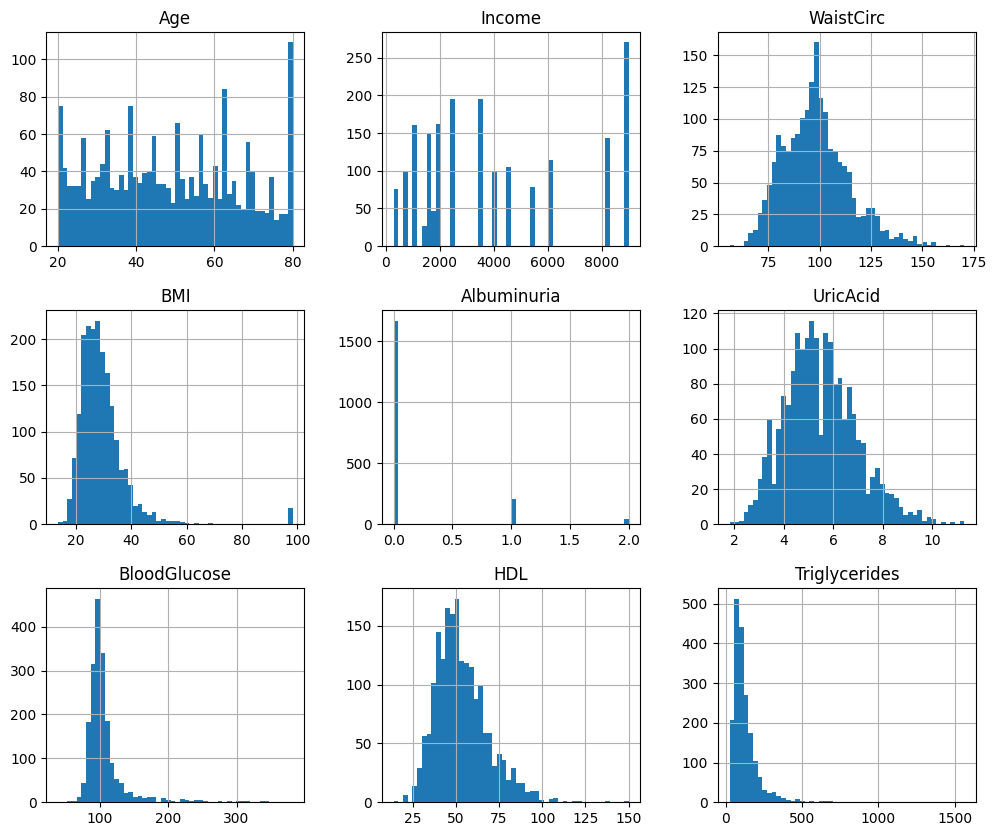

In [28]:
train_set[features_num].hist(bins=50, figsize=(12, 10))
plt.show()

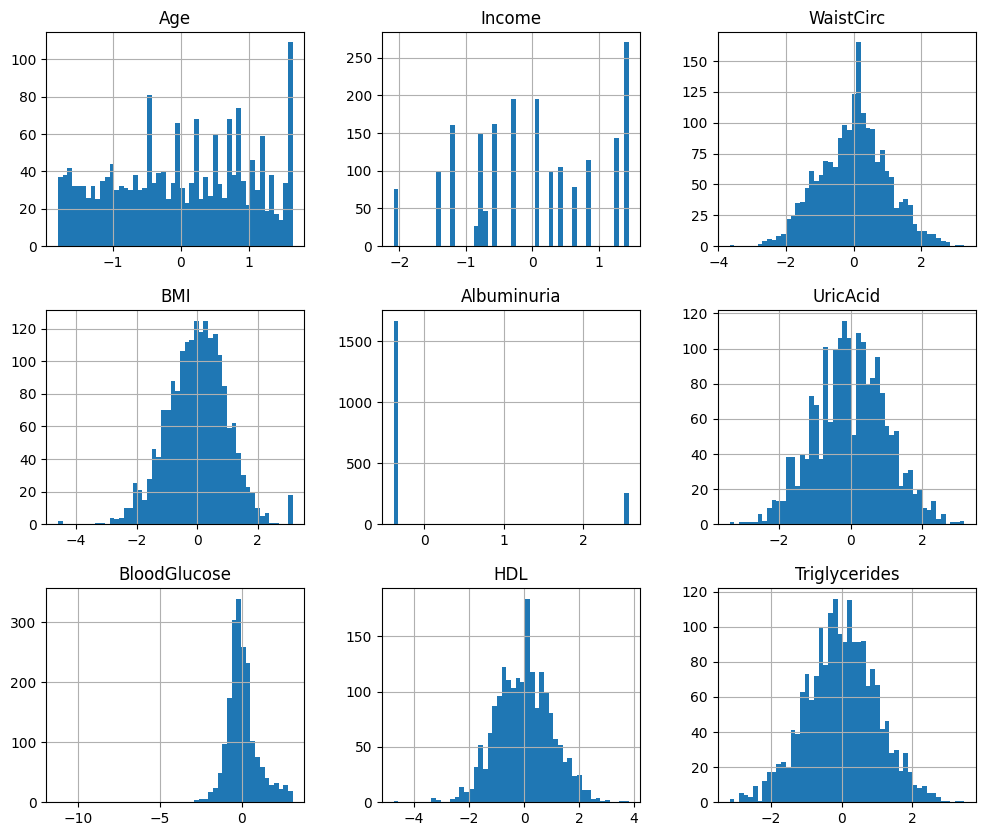

In [29]:
pt = PowerTransformer()
train_set_pt[features_num] = pt.fit_transform(train_set_pt[features_num])
test_set_pt[features_num] = pt.transform(test_set_pt[features_num]) 
train_set_pt[features_num].hist(bins=50, figsize=(12, 10))
plt.show()

- Voy a hacerle logaritmo antes de estandarizar a las siguientes columnas:
    - BloodGlucose
    - Triglycerides
    - HDL
    - BMI
    - Age
    - Income

In [30]:
features_num.remove("Albuminuria")
features_num

['Age',
 'Income',
 'WaistCirc',
 'BMI',
 'UricAcid',
 'BloodGlucose',
 'HDL',
 'Triglycerides']

In [31]:
train_set[features_num]= train_set[features_num].apply(np.log)

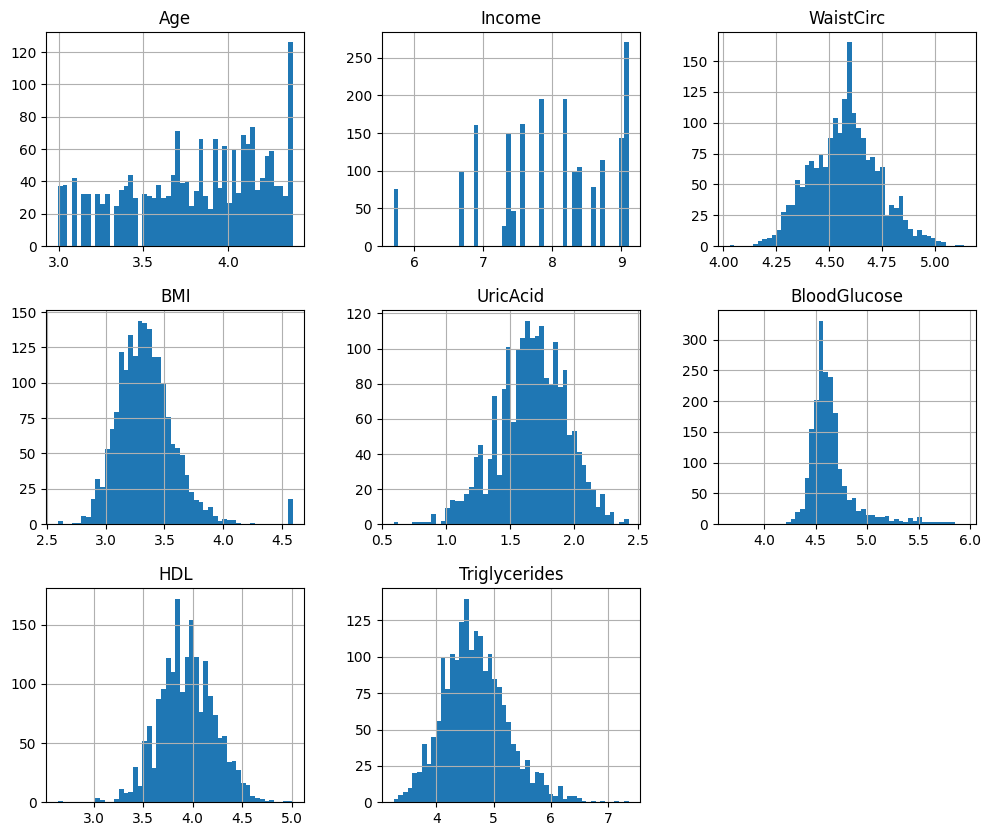

In [32]:
train_set[features_num].hist(bins=50, figsize=(12, 10))
plt.show()

In [33]:
train_set

,Age,Income,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome,...,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
651,3.637586,6.684612,4.955827,3.871201,1,1.960095,4.753590,4.077537,4.510860,1,...,0,0,1,0,0,1,0,0,0,0
1111,3.401197,9.104980,4.554929,3.335770,0,1.704748,4.634729,3.713572,6.059123,1,...,1,0,0,0,1,0,0,0,0,0
392,3.713572,8.732305,4.522875,3.295837,0,1.856298,4.543295,3.610918,3.258097,0,...,1,0,0,0,0,1,0,0,0,0
1877,3.988984,8.160518,4.631812,3.387774,0,1.856298,4.644391,3.610918,5.673323,1,...,1,0,0,0,0,0,1,0,0,0
962,4.330733,7.600902,4.439116,3.054001,1,2.261763,4.927254,4.025352,5.056246,1,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,3.044522,8.160518,4.415220,3.091042,0,1.458615,4.488636,3.871201,4.174387,0,...,1,0,0,0,0,0,1,0,0,0
2197,3.258097,7.600902,4.928702,3.795489,0,1.987874,4.672829,3.850148,4.718499,1,...,0,0,1,0,1,0,0,0,0,0
1242,3.931826,7.438384,4.387014,3.086487,0,1.308333,4.510860,4.077537,3.970292,0,...,0,1,0,0,0,0,0,1,0,0
1083,3.850148,7.824046,4.669084,3.360375,0,1.808289,4.532599,3.583519,5.036953,1,...,0,0,0,0,0,0,0,0,0,1


In [34]:
train_set_min_max= train_set.copy()
features_num.append("Albuminuria")
min_max_scaler = MinMaxScaler((0,1))
train_set_min_max[features_num]= min_max_scaler.fit_transform(train_set[features_num])
train_set_min_max


,Age,Income,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome,...,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
651,0.463000,0.288378,0.835191,0.640363,0.5,0.747031,0.477693,0.606550,0.305878,1,...,0,0,1,0,0,1,0,0,0,0
1111,0.292481,1.000000,0.473962,0.371645,0.0,0.608030,0.425604,0.453080,0.683907,1,...,1,0,0,0,1,0,0,0,0,0
392,0.517812,0.890428,0.445080,0.351603,0.0,0.690528,0.385534,0.409795,0.000000,0,...,1,0,0,0,0,1,0,0,0,0
1877,0.716480,0.722315,0.543238,0.397744,0.0,0.690528,0.429838,0.409795,0.589709,1,...,1,0,0,0,0,0,1,0,0,0
962,0.963000,0.557780,0.369609,0.230233,0.5,0.911248,0.553799,0.584545,0.439041,1,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,0.035195,0.722315,0.348077,0.248823,0.0,0.474045,0.361580,0.519546,0.223724,0,...,1,0,0,0,0,0,1,0,0,0
2197,0.189256,0.557780,0.810750,0.602366,0.0,0.762153,0.442300,0.510669,0.356576,1,...,0,0,1,0,1,0,0,0,0,0
1242,0.675249,0.509997,0.322663,0.246536,0.0,0.392237,0.371319,0.606550,0.173892,0,...,0,1,0,0,0,0,0,1,0,0
1083,0.616330,0.623387,0.576821,0.383994,0.0,0.664394,0.380846,0.398242,0.434331,1,...,0,0,0,0,0,0,0,0,0,1


In [35]:
test_set_min_max=test_set.copy()
test_set_min_max[features_num]= min_max_scaler.transform(test_set[features_num])

In [36]:
std_scaler = StandardScaler()
train_set[features_num]= std_scaler.fit_transform(train_set[features_num])
train_set

,Age,Income,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome,...,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
651,-0.447567,-1.477954,2.375942,2.094378,2.005644,1.091059,0.431366,0.493550,-0.303096,1,...,0,0,1,0,0,1,0,0,0,0
1111,-1.051174,1.281752,-0.124155,-0.035183,-0.367022,0.137560,-0.071390,-0.818896,2.484147,1,...,1,0,0,0,1,0,0,0,0,0
392,-0.253541,0.856828,-0.324052,-0.194006,-0.367022,0.703468,-0.458136,-1.189064,-2.558367,0,...,1,0,0,0,0,1,0,0,0,0
1877,0.449711,0.204876,0.355307,0.171655,-0.367022,0.703468,-0.030522,-1.189064,1.789616,1,...,1,0,0,0,0,0,1,0,0,0
962,1.322351,-0.433198,-0.846395,-1.155855,2.005644,2.217530,1.165922,0.305370,0.678729,1,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,-1.961927,0.204876,-0.995416,-1.008531,-0.367022,-0.781534,-0.689328,-0.250492,-0.908826,0,...,1,0,0,0,0,0,1,0,0,0
2197,-1.416576,-0.433198,2.206783,1.793251,-0.367022,1.194792,0.089764,-0.326410,0.070704,1,...,0,0,1,0,1,0,0,0,0,0
1242,0.303760,-0.618503,-1.171312,-1.026651,-0.367022,-1.342708,-0.595330,0.493550,-1.276246,0,...,0,1,0,0,0,0,0,1,0,0
1083,0.095199,-0.178770,0.587740,0.062681,-0.367022,0.524195,-0.503374,-1.287863,0.643997,1,...,0,0,0,0,0,0,0,0,0,1


In [37]:
test_set[features_num]= std_scaler.transform(test_set[features_num])

- Finalmente me quedo los siguientes juegos de features:
    - Todas las features escaladas con MinMaxScaler
    - Todas las features escaladas con StandardScaler
    - Todas las features escaldas con PoowerTransformer
    - Las features de los factores de riesgos escaladas con StandardScaler

### Modelado

#### Separamos en X,y 

In [38]:
#Juego de X, y de todas las features escaladas con StandardScaler
X_train_scaled= train_set.drop(columns=target)
y_train_scaled = train_set[target]
X_test_scaled= test_set.drop(columns=target)
y_test_scaled = test_set[target]

In [39]:
#Juego de X,y de todas las features escaladas con MinMaxScaler
X_train_min_max= train_set_min_max.drop(columns=target)
y_train_min_max = train_set_min_max[target]
X_test_min_max= test_set_min_max.drop(columns=target)
y_test_min_max = test_set_min_max[target]

In [40]:
#Juego de X,y de todas las features escaladas con PowerTransform
X_train_pt= train_set_pt.drop(columns=target)
y_train_pt = train_set_pt[target]
X_test_pt= test_set_pt.drop(columns=target)
y_test_pt = test_set_pt[target]

#### Baseline

In [41]:
model_names = ["Logistic Regression","Arbol de Decision","Random Forest","XGBoost","LightGBM","Catboost", "SVC", "KNN"]
rf_clf = RandomForestClassifier(random_state= 42, class_weight= "balanced")
xgb_clf = XGBClassifier(verbosity= 0, random_state = 42, scale_pos_weight=70/30)
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100, class_weight= 'balanced')
lg_clf = LogisticRegression(max_iter = 10000, class_weight= 'balanced')
cat_clf = CatBoostClassifier(random_state= 42, verbose= False, auto_class_weights='Balanced')
tree_clf = DecisionTreeClassifier(random_state= 42, class_weight= "balanced")
svc = SVC(random_state= 42, class_weight='balanced')
knn_clf = KNeighborsClassifier(n_neighbors= 4)

model_set = [rf_clf, xgb_clf, lgb_clf,lg_clf,cat_clf,tree_clf,svc, knn_clf]

scorer = make_scorer(recall_score, pos_label=1)


In [42]:
#Hacemos un CrossValidation con varios modelos y las features escaladas con StandardScaler
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y_train_scaled, cv = 5, scoring = scorer)
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

RandomForestClassifier(class_weight='balanced', random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
LGBMClassifier(class_weight='balanced', random_state=42, verbose=-100)
LogisticRegression(class_weight='balanced', max_iter=10000)
DecisionTreeClassifier(class_weight='balanced', 

In [43]:
data= []
for model_name, valores in metricas_cv.items():
    data.append({'Modelo': model_name, 'Recall_CV': np.mean(valores)})


df = pd.DataFrame(data)


print(df)
print(f"El ganador es {ganador}")

                Modelo  Recall_CV
0  Logistic Regression   0.782373
1    Arbol de Decision   0.847791
2        Random Forest   0.858443
3              XGBoost   0.831066
4             LightGBM   0.890423
5             Catboost   0.754973
6                  SVC   0.866031
7                  KNN   0.541846
El ganador es LightGBM


In [44]:
#Hacemos un CrossValidation con varios modelos y las features escaladas con MinMaxScaler
metricas_cv_2 = {}
valores_2 = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    metricas_cv_2[nombre] = cross_val_score(modelo, X_train_min_max, y_train_min_max, cv = 5, scoring = scorer)
    valores_2.append(np.mean(metricas_cv_2[nombre]))
ganador_2 = list(metricas_cv_2.keys())[np.argmax(valores_2)]

RandomForestClassifier(class_weight='balanced', random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
LGBMClassifier(class_weight='balanced', random_state=42, verbose=-100)
LogisticRegression(class_weight='balanced', max_iter=10000)
DecisionTreeClassifier(class_weight='balanced', 

In [45]:
data_2= []
for model_name, valores_3 in metricas_cv_2.items():
    data_2.append({'Modelo': model_name, 'Recall_CV': np.mean(valores_2)})


df_2 = pd.DataFrame(data_2)


print(df_2)
print(f"El ganador es {ganador_2}")

                Modelo  Recall_CV
0  Logistic Regression   0.769039
1    Arbol de Decision   0.769039
2        Random Forest   0.769039
3              XGBoost   0.769039
4             LightGBM   0.769039
5             Catboost   0.769039
6                  SVC   0.769039
7                  KNN   0.769039
El ganador es LightGBM


In [46]:
#Hacemos un CrossValidation con varios modelos y las features escaladas con PowerTransformer
metricas_cv_3 = {}
valores_3 = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    metricas_cv_3[nombre] = cross_val_score(modelo, X_train_pt, y_train_pt, cv = 5, scoring = scorer)
    valores_3.append(np.mean(metricas_cv_3[nombre]))
ganador_3 = list(metricas_cv_3.keys())[np.argmax(valores_3)]

RandomForestClassifier(class_weight='balanced', random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
LGBMClassifier(class_weight='balanced', random_state=42, verbose=-100)
LogisticRegression(class_weight='balanced', max_iter=10000)
DecisionTreeClassifier(class_weight='balanced', 

In [47]:
data_3= []
for model_name, valores_3 in metricas_cv_3.items():
    data_3.append({'Modelo': model_name, 'Recall_CV': np.mean(valores_3)})


df_3 = pd.DataFrame(data_3)


print(df_3)
print(f"El ganador es {ganador_3}")

                Modelo  Recall_CV
0  Logistic Regression   0.783900
1    Arbol de Decision   0.847791
2        Random Forest   0.855424
3              XGBoost   0.834074
4             LightGBM   0.890423
5             Catboost   0.754973
6                  SVC   0.872114
7                  KNN   0.546426
El ganador es LightGBM


- Los modelos que nos dan el mejor Recall solo los probados con las features a las que se le hizo el PowerTransformer, asi que voy a entrenar un RandomForest para ver las features importances, usando éstas features

In [48]:
rf_clf = RandomForestClassifier(random_state= 42, class_weight= "balanced")
rf_clf.fit(X_train_pt, y_train_pt)

feature_names = X_train_pt.columns
importances = rf_clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
6,BloodGlucose,0.201402
8,Triglycerides,0.175354
2,WaistCirc,0.172906
7,HDL,0.105089
3,BMI,0.098911
0,Age,0.069523
5,UricAcid,0.050544
1,Income,0.031823
9,Sex_Female,0.013182
10,Sex_Male,0.011821


- Me voy a quedar con las primeras 11 features porque con ellas alcanzco más del 80% de información y voy a volver hacer el CroosValidation pero con éstas nuevas features.

In [49]:
fe_impor = feature_importance_df.Feature.to_list()[0:11]

In [50]:
metricas_cv_4 = {}
valores_4 = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    metricas_cv_4[nombre] = cross_val_score(modelo, X_train_pt[fe_impor], y_train_pt, cv = 4, scoring = scorer)
    valores_4.append(np.mean(metricas_cv_4[nombre]))
ganador_4 = list(metricas_cv_4.keys())[np.argmax(valores_4)]

RandomForestClassifier(class_weight='balanced', random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
LGBMClassifier(class_weight='balanced', random_state=42, verbose=-100)
LogisticRegression(class_weight='balanced', max_iter=10000)
DecisionTreeClassifier(class_weight='balanced', 

In [51]:
data_4= []
for model_name, valores_4 in metricas_cv_4.items():
    data_4.append({'Modelo': model_name, 'Recall_CV': np.mean(valores_4)})


df_4 = pd.DataFrame(data_4)


print(df_4)
print(f"El ganador es {ganador_4}")

                Modelo  Recall_CV
0  Logistic Regression   0.808232
1    Arbol de Decision   0.861502
2        Random Forest   0.844762
3              XGBoost   0.846249
4             LightGBM   0.882825
5             Catboost   0.759460
6                  SVC   0.867600
7                  KNN   0.595085
El ganador es LightGBM


- Finalmente me voy a quedar con todas las features escaladas con PowerTransformer, ya que es la que me da mejores resultados y voy a hacer un GridSearch.

In [52]:
metricas_optimizadas = {}

In [53]:
rf_clf = RandomForestClassifier(random_state= 42)
param_grid_rf = {"n_estimators": [50,100,200],
    "max_depth": [None,20,30],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1,5,10],
    "max_features": ["sqrt","log2",None],
    "class_weight": ["balanced", None],
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid= param_grid_rf,
                       cv = 5,
                       scoring = scorer)

rf_grid.fit(X_train_pt, y_train_pt)
print("Random_forest_score:", rf_grid.best_score_)
metricas_optimizadas["Random_Forest"] = rf_grid.best_score_

Random_forest_score: 0.9117279666897987


In [54]:
xgb_clf = XGBClassifier(verbosity= 0, random_state = 42, scale_pos_weight=70/30)
param_grid_xgb= {'n_estimators': [50, 100, 200],
       'learning_rate': [0.01, 0.05, 0.1],
       'max_depth': [3, 5, 7],
       'subsample': [0.6, 0.8, 1.0],
       'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb_clf, 
                        cv = 5,
                        param_grid= param_grid_xgb, 
                        scoring = scorer)


xgb_grid.fit(X_train_pt, y_train_pt)
print("XGB_score:", xgb_grid.best_score_)
metricas_optimizadas["XGBoost"] = xgb_grid.best_score_

XGB_score: 0.9696044413601665


In [55]:
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100)
param_grid_lgb= {"max_depth": [-1,5,10],
                 "num_leaves": [31, 50],
                "learning_rate": [0.1, 0.01],
                "n_estimators": [100, 200],
                "class_weight": ["balanced", None], 
                "min_child_samples": [20, 30],
                "subsample": [0.8, 1.0],
                "colsample_bytree": [0.8, 1.0]
}

lgb_grid = GridSearchCV(lgb_clf, 
                        cv = 5,
                        param_grid= param_grid_lgb, 
                        scoring = scorer)


lgb_grid.fit(X_train_pt, y_train_pt)
print("LGB_score:", lgb_grid.best_score_)
metricas_optimizadas["LightGBM"] = lgb_grid.best_score_

LGB_score: 0.9269720101781169


In [56]:
tree_clf = DecisionTreeClassifier(random_state= 42)
param_grid_tree = {"criterion": ["gini","entropy"],
                   "splitter": ["best", "random"],
                   "max_depth": [None,20,30,40],
                   "min_samples_split":[2,10,20],
                   "min_samples_leaf":[1,5,10],
                   "max_features": ["sqrt","log2",None],
                   "class_weight": ["balanced", None]
}

tree_grid = GridSearchCV(tree_clf,
                       param_grid= param_grid_tree,
                       cv = 5,
                       scoring = scorer)

tree_grid.fit(X_train_pt, y_train_pt)
print("Arbol_Descición_score:", tree_grid.best_score_)
metricas_optimizadas["Arbol_Descición"] = tree_grid.best_score_

Arbol_Descición_score: 0.8919731667823271


In [57]:
lg_clf = LogisticRegression(random_state=42)
param_grid_lg= {"C":[0.01, 0.1, 1, 10],
                "max_iter":[100,1000],
                "class_weight":["balanced",None]
}

lg_grid = GridSearchCV(lg_clf,
                       param_grid= param_grid_lg,
                       cv = 5,
                       scoring = scorer)

lg_grid.fit(X_train_pt, y_train_pt)
print("Regresión_Logística_score:", lg_grid.best_score_)
metricas_optimizadas["Regresión_Logística"] = lg_grid.best_score_

Regresión_Logística_score: 0.8416840157298173


In [58]:
knn_clf = KNeighborsClassifier()
param_grid_knn= {"n_neighbors":[3,4,5],
                 "weights":['uniform', 'distance'],
                 "metric":["manhattan","euclidean","chebyshev"]
}

knn_grid = GridSearchCV(knn_clf,
                       param_grid= param_grid_knn,
                       cv = 5,
                       scoring = scorer)

knn_grid.fit(X_train_pt, y_train_pt)
print("KNN_score:", knn_grid.best_score_)
metricas_optimizadas["KNN"] = knn_grid.best_score_

KNN_score: 0.6833911635438353


In [59]:
cat_clf = CatBoostClassifier(random_state= 42, verbose= False)
param_grid_cat= {"iterations": [100, 300], 
    "learning_rate": [0.01, 0.05, 0.1],  
    "depth": [4, 6, 8],  
    "l2_leaf_reg": [1, 3, 5], 
    "auto_class_weights": ["Balanced"]
}

cat_grid = GridSearchCV(cat_clf,
                       param_grid= param_grid_cat,
                       cv = 5,
                       scoring = scorer)

cat_grid.fit(X_train_pt, y_train_pt)
print("CatBoost_score:", cat_grid.best_score_)
metricas_optimizadas["CatBoost"] = cat_grid.best_score_

CatBoost_score: 0.9178117048346056


In [60]:
svc = SVC(random_state= 42)
param_grid_svc= {"C":[0.01, 0.1, 1, 10, 100],
                 "kernel":['linear', 'poly', 'rbf', 'sigmoid'],
                 "gamma":['scale', 'auto'],
                 "class_weight":["balanced",None]
}

svc_grid = GridSearchCV(svc,
                       param_grid= param_grid_svc,
                       cv = 5,
                       scoring = scorer)

svc_grid.fit(X_train_pt, y_train_pt)
print("SVC_score:", svc_grid.best_score_)
metricas_optimizadas["SVC"] = svc_grid.best_score_

SVC_score: 0.890411751098774


In [61]:
metricas_optimizadas

{'Random_Forest': 0.9117279666897987,
 'XGBoost': 0.9696044413601665,
 'LightGBM': 0.9269720101781169,
 'Arbol_Descición': 0.8919731667823271,
 'Regresión_Logística': 0.8416840157298173,
 'KNN': 0.6833911635438353,
 'CatBoost': 0.9178117048346056,
 'SVC': 0.890411751098774}

In [62]:
print(xgb_grid.best_params_)
print(xgb_grid.best_score_)

{'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
0.9696044413601665


In [63]:
y_pred = xgb_grid.best_estimator_.predict(X_test_pt)
print(classification_report(y_test_pt, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       316
           1       0.68      0.96      0.80       165

    accuracy                           0.83       481
   macro avg       0.83      0.86      0.83       481
weighted avg       0.87      0.83      0.84       481

